#Download Dataset

In [8]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls -l ~/.kaggle

total 4
-rw------- 1 root root 67 Nov 11 12:02 kaggle.json


In [11]:
!kaggle competitions download -c novozymes-enzyme-stability-prediction

 99% 7.00M/7.06M [00:01<00:00, 6.77MB/s]
100% 7.06M/7.06M [00:01<00:00, 3.75MB/s]


In [12]:
!unzip novozymes-enzyme-stability-prediction.zip

Archive:  novozymes-enzyme-stability-prediction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
  inflating: train_updates_20220929.csv  
  inflating: wildtype_structure_prediction_af2.pdb  


In [13]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import opendatasets as op
op.download("https://www.kaggle.com/datasets/googleai/pfam-seed-random-split")

100%|██████████| 493M/493M [00:35<00:00, 14.7MB/s]


In [15]:
dataset_folder = "pfam-seed-random-split/random_split"
filters = 64
epochs = 60
batch_size = 128
protein_len = 200
protein_family_number = 600

#Import Packages

In [96]:
import tensorflow as tf
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import add, maximum, minimum
import tensorflow_probability as tfp
tfd = tfp.distributions 
tfpl = tfp.layers
from keras import regularizers
import pandas as pd
import numpy as np
import os

#Read Dataset

In [58]:
def read_data(name_sub_folder):
  full_data = []
  for f in os.listdir(os.path.join(dataset_folder, name_sub_folder)):
    data = pd.read_csv(os.path.join(dataset_folder, name_sub_folder, f))
    full_data.append(data)
  return pd.concat(full_data)  

In [59]:
dataset_train = read_data("train")
dataset_train.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,IMPDH,Q0P9J4_CAMJE/7-469,PF00478.25,ALTFEDVLLRPGYS..EVLPK.EVKIHTKLT....K.N......IT...,ALTFEDVLLRPGYSEVLPKEVKIHTKLTKNITLNMPLISAAMDTVT...
1,SpoIIAA-like,A0A1N0ZRF1_9MYCO/12-121,PF11964.8,VVGFRVS...GR......LTGNELRE.FTSTI..........KEAL...,VVGFRVSGRLTGNELREFTSTIKEALNGDELRIVEVIASDYEGFGP...
2,ALS_ss_C,C9RN45_FIBSS/87-160,PF10369.9,KELALIKVRCTA......E.QRTE.ILQLC..DHF....HANTVDM...,KELALIKVRCTAEQRTEILQLCDHFHANTVDMTMTSMIIQITGNSQ...
3,DUF3767,T0KI99_COLGC/87-187,PF12597.8,PTTAWEVVKNIK.SEDFT..TFAQAPCARDGLLTGIAAGFVVGGLR...,PTTAWEVVKNIKSEDFTTFAQAPCARDGLLTGIAAGFVVGGLRLVF...
4,Oxygenase-NA,D3EL69_GEOS4/65-236,PF09859.9,GEYKYYQAPLP..ETLQQLREGLYPELALTANRWLNRLGHEEKYPA...,GEYKYYQAPLPETLQQLREGLYPELALTANRWLNRLGHEEKYPASL...


In [60]:
dataset_test = read_data("test")
dataset_test.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,GNAT_acetyltran,R6RQF6_9CLOT/17-251,PF12746.7,AFLFSGR..REVMAD....ACLQGMM..GCVYG..........TAG...,AFLFSGRREVMADACLQGMMGCVYGTAGGMDSAAAVLGDFCFLAGK...
1,MoaC,W5NKR5_LEPOC/505-640,PF01967.21,MVDVGGK.PVSRRTAAASATVLLG.EK..........AFWLV.......,MVDVGGKPVSRRTAAASATVLLGEKAFWLVKENQLAKGDALAVAQI...
2,Methyltransf_25,C0QLU8_DESAH/50-147,PF13649.6,VLDVACGT.C...D..VA...ME..AR.NQ.......T....G......,VLDVACGTCDVAMEARNQTGDAAFIIGTDFSPGMLTLGLQKLKKNR...
3,EMG1,T1G7Q2_HELRO/22-222,PF03587.14,VVLERASLESVKV..G.................KEYQLLN....CD...,VVLERASLESVKVGKEYQLLNCDRHKGIAKKFKRDISTCRPDITHQ...
4,Glyco_hydro_30C,C6VRM9_DYAFD/453-540,PF17189.4,GAVRVDVSGGLGTD...............AMVVSSYLN..TDKSLV...,GAVRVDVSGGLGTDAMVVSSYLNTDKSLVTVIVNADNQDRDISLAI...


In [61]:
dataset_dev = read_data("dev")
dataset_dev.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,zf-Tim10_DDP,N1QB11_PSEFD/15-76,PF02953.15,..RMEKKQMKDFMNMYSNLVQRCFNDCV...........TD.F......,RMEKKQMKDFMNMYSNLVQRCFNDCVTDFTSKSLQSKEEGCVMRCV...
1,DNA_primase_S,A8XA78_CAEBR/105-345,PF01896.19,FDID..LTDYDNIRNCCKEATVCPKCWKFMVLAVKILDFLLDDMFG...,FDIDLTDYDNIRNCCKEATVCPKCWKFMVLAVKILDFLLDDMFGFN...
2,Col_cuticle_N,A8XBM5_CAEBR/9-56,PF01484.17,ASAAILSGATIVGCLFFAAQIFNEVNSLYDDVMVDMDAFKVKSNIA...,ASAAILSGATIVGCLFFAAQIFNEVNSLYDDVMVDMDAFKVKSNIAWD
3,GST_C_3,W4XBU3_STRPU/120-207,PF14497.6,KD.................................KLKESLPKTVN...,KDKLKESLPKTVNPILLKFLEKALEDNPNGNGYFVGQDATMVEFVY...
4,Ada_Zn_binding,E8U5K2_DEIML/9-73,PF02805.16,DRWQAVVQRE...AAQ.DG...LFLYAVRTTGIYCRPSCPSRRPR....,DRWQAVVQREAAQDGLFLYAVRTTGIYCRPSCPSRRPRRENVTFFE...


In [62]:
dataset_train = pd.concat([dataset_train, dataset_test])

In [63]:
dataset_train.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,IMPDH,Q0P9J4_CAMJE/7-469,PF00478.25,ALTFEDVLLRPGYS..EVLPK.EVKIHTKLT....K.N......IT...,ALTFEDVLLRPGYSEVLPKEVKIHTKLTKNITLNMPLISAAMDTVT...
1,SpoIIAA-like,A0A1N0ZRF1_9MYCO/12-121,PF11964.8,VVGFRVS...GR......LTGNELRE.FTSTI..........KEAL...,VVGFRVSGRLTGNELREFTSTIKEALNGDELRIVEVIASDYEGFGP...
2,ALS_ss_C,C9RN45_FIBSS/87-160,PF10369.9,KELALIKVRCTA......E.QRTE.ILQLC..DHF....HANTVDM...,KELALIKVRCTAEQRTEILQLCDHFHANTVDMTMTSMIIQITGNSQ...
3,DUF3767,T0KI99_COLGC/87-187,PF12597.8,PTTAWEVVKNIK.SEDFT..TFAQAPCARDGLLTGIAAGFVVGGLR...,PTTAWEVVKNIKSEDFTTFAQAPCARDGLLTGIAAGFVVGGLRLVF...
4,Oxygenase-NA,D3EL69_GEOS4/65-236,PF09859.9,GEYKYYQAPLP..ETLQQLREGLYPELALTANRWLNRLGHEEKYPA...,GEYKYYQAPLPETLQQLREGLYPELALTANRWLNRLGHEEKYPASL...


In [64]:
dataset_train['family_accession'].value_counts()

PF13649.6     4091
PF00560.33    2167
PF13508.7     1980
PF06580.13    1729
PF02397.16    1718
              ... 
PF17055.5        1
PF09096.10       1
PF06503.11       1
PF13198.6        1
PF13321.6        1
Name: family_accession, Length: 17929, dtype: int64

## Select until 600 family

In [65]:
classes = dataset_train['family_accession'].value_counts()[:protein_family_number].index

In [66]:
def return_from_dataset(dataset, classes):
  return [dataset.loc[dataset['family_accession'].isin(classes)].reset_index(), classes]

In [67]:
[dataset_train, classes] = return_from_dataset(dataset_train, classes) 

In [68]:
dataset_train.head()

,index,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,0,IMPDH,Q0P9J4_CAMJE/7-469,PF00478.25,ALTFEDVLLRPGYS..EVLPK.EVKIHTKLT....K.N......IT...,ALTFEDVLLRPGYSEVLPKEVKIHTKLTKNITLNMPLISAAMDTVT...
1,2,ALS_ss_C,C9RN45_FIBSS/87-160,PF10369.9,KELALIKVRCTA......E.QRTE.ILQLC..DHF....HANTVDM...,KELALIKVRCTAEQRTEILQLCDHFHANTVDMTMTSMIIQITGNSQ...
2,6,SpaA,N4WNB1_9BACI/1350-1420,PF17802.1,INGD..VL..EGATFTLT...YQ..........................,INGDVLEGATFTLTYQDGNYSSEVLEGTTDSSGKVTFTNLKPGTYS...
3,7,MoaC,Q6AAG5_CUTAK/17-150,PF01967.21,MVDVTTK.TPTVRVATAECCVVCS.EP..........IMTAL.......,MVDVTTKTPTVRVATAECCVVCSEPIMTALRDESVPKGDVLAVARI...
4,9,GlutR_N,D0J057_COMT2/6-161,PF05201.15,LGINHHTAP...........LDMRGRFAF....A.LDQ.IAPTLQG...,LGINHHTAPLDMRGRFAFALDQIAPTLQGLRASLSHAGRAHSAVET...


In [69]:
classes

Index(['PF13649.6', 'PF00560.33', 'PF13508.7', 'PF06580.13', 'PF02397.16',
       'PF00677.17', 'PF01035.20', 'PF02417.15', 'PF13472.6', 'PF00684.19',
       ...
       'PF00681.20', 'PF00813.20', 'PF02570.15', 'PF01176.19', 'PF00447.17',
       'PF00338.22', 'PF12392.8', 'PF07963.12', 'PF01944.17', 'PF00858.24'],
      dtype='object', length=600)

In [70]:
[dataset_dev, classes_dev] = return_from_dataset(dataset_dev, classes) 

In [71]:
dataset_dev.head()

,index,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,0,zf-Tim10_DDP,N1QB11_PSEFD/15-76,PF02953.15,..RMEKKQMKDFMNMYSNLVQRCFNDCV...........TD.F......,RMEKKQMKDFMNMYSNLVQRCFNDCVTDFTSKSLQSKEEGCVMRCV...
1,8,HSF_DNA-bind,I2GV49_TETBL/163-265,PF00447.17,FVNKLWNM...L.....N..........DP...................,FVNKLWNMLNDPINQDMIRWSDDGKSFLVVNREKFVHHVLPNYFKH...
2,9,MacB_PCD,A6X4W0_OCHA4/276-497,PF12704.7,TFL.TMLGIIIG..TASVVCVV.ALGQGSQRQILER..IS.....D...,TFLTMLGIIIGTASVVCVVALGQGSQRQILERISDLGTNTLYISPG...
3,10,CDP-OH_P_transf,F4CUG5_PSEUX/16-81,PF01066.21,TVPNALSV..LRLL...G....V.PL.......................,TVPNALSVLRLLGVPLFLYLLLGPHADGWAILVLAVGGVTDWLDGK...
4,12,DUF72,E8WY12_GRATM/44-259,PF01904.18,YPAKTSA.KN.FLGFYASQ..LNSVEVNFTF........RK.LPTE...,YPAKTSAKNFLGFYASQLNSVEVNFTFRKLPTEAQLNGWLAQTGEG...


In [72]:
def features_target_split(dataset):
  return [dataset['sequence'], dataset['family_accession']]

In [73]:
[features, target] = features_target_split(dataset_train)
[features_dev, target_dev] = features_target_split(dataset_dev)

In [74]:
len(classes)

600

##Preprocessing dataset

In [75]:
def cut_protein_sequence(sequence):
  return sequence.apply(lambda seq: [seq[i:i+ 1] for i in range(0, len(seq), 1)])

In [76]:
features = cut_protein_sequence(features)
features_dev = cut_protein_sequence(features_dev)

In [77]:
features

0         [A, L, T, F, E, D, V, L, L, R, P, G, Y, S, E, ...
1         [K, E, L, A, L, I, K, V, R, C, T, A, E, Q, R, ...
2         [I, N, G, D, V, L, E, G, A, T, F, T, L, T, Y, ...
3         [M, V, D, V, T, T, K, T, P, T, V, R, V, A, T, ...
4         [L, G, I, N, H, H, T, A, P, L, D, M, R, G, R, ...
                                ...                        
370647    [V, A, V, L, G, L, T, A, L, G, V, W, Q, V, Q, ...
370648    [K, I, N, I, S, S, K, I, P, I, S, C, G, L, G, ...
370649    [F, I, V, C, S, L, I, T, G, L, S, D, G, S, A, ...
370650    [I, S, T, S, Q, L, N, N, W, L, N, M, T, Q, E, ...
370651    [D, T, P, D, L, V, M, A, E, R, N, K, S, L, Y, ...
Name: sequence, Length: 370652, dtype: object

In [78]:
features_dev

0        [R, M, E, K, K, Q, M, K, D, F, M, N, M, Y, S, ...
1        [F, V, N, K, L, W, N, M, L, N, D, P, I, N, Q, ...
2        [T, F, L, T, M, L, G, I, I, I, G, T, A, S, V, ...
3        [T, V, P, N, A, L, S, V, L, R, L, L, G, V, P, ...
4        [Y, P, A, K, T, S, A, K, N, F, L, G, F, Y, A, ...
                               ...                        
40879    [L, V, E, A, D, G, I, M, D, M, I, S, A, K, N, ...
40880    [L, S, T, P, E, L, T, R, L, L, E, A, A, V, M, ...
40881    [K, Y, E, I, M, M, I, L, K, P, D, L, E, D, D, ...
40882    [T, P, L, A, D, V, M, T, E, V, A, A, T, A, R, ...
40883    [L, Q, E, L, H, M, L, V, V, L, A, E, E, L, N, ...
Name: sequence, Length: 40884, dtype: object

In [79]:
label_ = preprocessing.LabelEncoder()
label_.fit(target)

LabelEncoder()

In [80]:
label_.classes_

array(['PF00003.22', 'PF00006.25', 'PF00013.29', 'PF00020.18',
       'PF00023.30', 'PF00036.32', 'PF00037.27', 'PF00080.20',
       'PF00095.21', 'PF00100.23', 'PF00115.20', 'PF00119.20',
       'PF00126.27', 'PF00137.21', 'PF00140.20', 'PF00146.21',
       'PF00162.19', 'PF00163.19', 'PF00174.19', 'PF00177.21',
       'PF00200.23', 'PF00221.19', 'PF00231.19', 'PF00237.19',
       'PF00241.20', 'PF00252.18', 'PF00271.31', 'PF00276.20',
       'PF00278.22', 'PF00281.19', 'PF00285.21', 'PF00288.26',
       'PF00298.19', 'PF00303.19', 'PF00312.22', 'PF00318.20',
       'PF00327.20', 'PF00329.19', 'PF00330.20', 'PF00333.20',
       'PF00338.22', 'PF00343.20', 'PF00344.20', 'PF00348.17',
       'PF00349.21', 'PF00358.20', 'PF00365.20', 'PF00366.20',
       'PF00367.20', 'PF00380.19', 'PF00381.19', 'PF00391.23',
       'PF00397.26', 'PF00400.32', 'PF00410.19', 'PF00433.24',
       'PF00438.20', 'PF00447.17', 'PF00453.18', 'PF00471.20',
       'PF00472.20', 'PF00475.18', 'PF00476.20', 'PF004

In [81]:
target = label_.transform(target)

In [82]:
target_dev = label_.transform(target_dev)

In [83]:
target = tf.keras.utils.to_categorical(target)
target_dev = tf.keras.utils.to_categorical(target_dev)

In [87]:
tokenizer_seq=  Tokenizer(num_words = 2000)
tokenizer_seq.fit_on_texts(features)

In [88]:
features = tokenizer_seq.texts_to_sequences(features)
features_dev = tokenizer_seq.texts_to_sequences(features_dev)

In [91]:
features = pad_sequences(features, maxlen = 200, padding = "post", truncating = "post")
features.shape

(370652, 200)

In [92]:
features_dev = pad_sequences(features_dev, maxlen = features.shape[1], padding = "post", truncating = "post")

In [242]:
features_dev.shape

(40884, 200)

In [93]:
print(tokenizer_seq.word_index)

{'l': 1, 'a': 2, 'g': 3, 'v': 4, 'i': 5, 'e': 6, 's': 7, 'r': 8, 'd': 9, 't': 10, 'k': 11, 'p': 12, 'f': 13, 'n': 14, 'q': 15, 'y': 16, 'm': 17, 'h': 18, 'c': 19, 'w': 20, 'x': 21, 'u': 22, 'b': 23}


In [94]:
vocabulary = len(tokenizer_seq.word_index)

#CNN Model

In [101]:
def resnet_con(inputs, filters, activation = "relu", strides = 1):
  x = tf.keras.layers.BatchNormalization()(inputs)
  x = tf.keras.layers.Conv1D(filters, 3, strides = strides, activation = activation, padding = "same",
                             kernel_regularizer=tf.keras.regularizers.L2(0.01))(x)
  x = tf.keras.layers.Activation("relu")(x)
  return x

In [102]:
filters = 64
input = tf.keras.layers.Input(shape=(features.shape[1], ))
x = tf.keras.layers.Embedding(vocabulary + 1, 150)(input)
x1 = tf.keras.layers.AveragePooling1D()(x)
x2 = tf.keras.layers.MaxPooling1D()(x)
x = tf.keras.layers.concatenate([x1, x2])
x = tf.keras.layers.Dropout(0.3)(x)
x = resnet_con(x, filters)
for stack in range(2):
  for block in range(3):
    strides = 1
    if stack > 0 and block == 0:
      strides = 2
    y = resnet_con(x, filters, activation = None, strides = strides)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Conv1D(filters, 3, activation = None, padding = "same",
                               kernel_regularizer=tf.keras.regularizers.L2(0.01))(y)                       
    if stack > 0 and block == 0:
      strides = 2
      x = tf.keras.layers.Conv1D(filters , 1, activation = None, strides = strides, padding = "same",
                                 kernel_regularizer=tf.keras.regularizers.L2(0.01))(x)
    x = add([x, y])
    x = tf.keras.layers.Activation("relu")(x)
  filters *=2
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.7)(x)
x = tf.keras.layers.Dense(1024, activation = "relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(512, activation = "relu")(x)
x = tf.keras.layers.Dropout(0.45)(x)
y = tf.keras.layers.Dense(len(classes), activation ="softmax",
                          kernel_regularizer=tf.keras.regularizers.L2(0.0001))(x)
m = tf.keras.models.Model(input, y)
m.compile(optimizer = tf.optimizers.Adam(learning_rate=0.001), loss = "categorical_crossentropy", metrics = ['accuracy'])
m.summary()     

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 200, 150)     3600        ['input_3[0][0]']                
                                                                                                  
 average_pooling1d_2 (AveragePo  (None, 100, 150)    0           ['embedding_2[0][0]']            
 oling1D)                                                                                         
                                                                                                  
 max_pooling1d_1 (MaxPooling1D)  (None, 100, 150)    0           ['embedding_2[0][0]']        

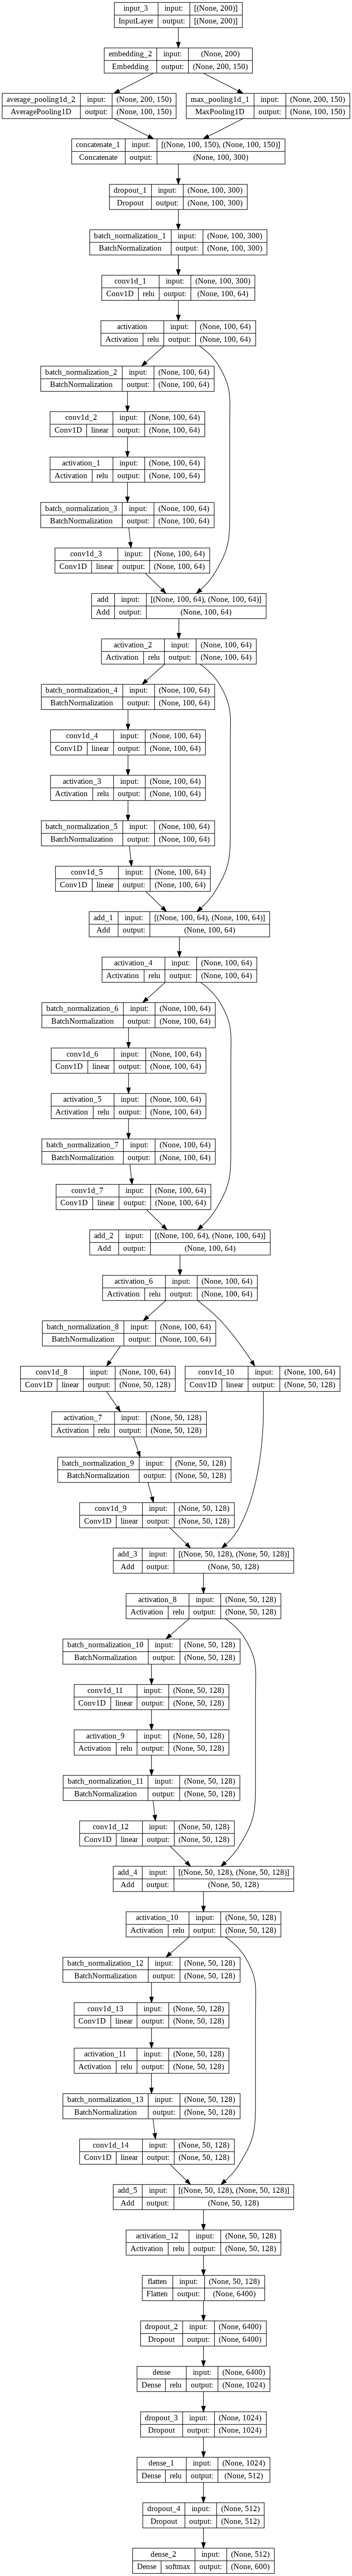

In [103]:
tf.keras.utils.plot_model(m, show_shapes = True, show_layer_activations= True)

#Training Model

In [104]:
history = m.fit(features, target, epochs = 60, batch_size = 128,
                validation_data = (features_dev, target_dev), 
               callbacks = [tf.keras.callbacks.EarlyStopping(patience = 6, 
                                                              monitor = 'val_loss', 
                                                              mode = 'min', 
                                                              restore_best_weights=True)])

Epoch 1/60
2896/2896 [==============================] - 107s 33ms/step - loss: 4.1959 - accuracy: 0.3721 - val_loss: 1.1509 - val_accuracy: 0.8226
Epoch 2/60
2896/2896 [==============================] - 94s 32ms/step - loss: 1.2137 - accuracy: 0.7924 - val_loss: 0.5873 - val_accuracy: 0.9330
Epoch 3/60
2896/2896 [==============================] - 94s 32ms/step - loss: 0.8149 - accuracy: 0.8679 - val_loss: 0.4343 - val_accuracy: 0.9551
Epoch 4/60
2896/2896 [==============================] - 94s 32ms/step - loss: 0.6561 - accuracy: 0.8935 - val_loss: 0.3817 - val_accuracy: 0.9593
Epoch 5/60
2896/2896 [==============================] - 94s 32ms/step - loss: 0.5701 - accuracy: 0.9072 - val_loss: 0.3178 - val_accuracy: 0.9699
Epoch 6/60
2896/2896 [==============================] - 94s 32ms/step - loss: 0.5152 - accuracy: 0.9161 - val_loss: 0.2910 - val_accuracy: 0.9734
Epoch 7/60
2896/2896 [==============================] - 93s 32ms/step - loss: 0.4781 - accuracy: 0.9236 - val_loss: 0.2864 

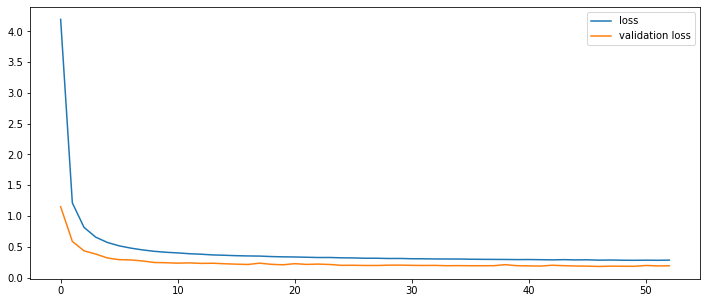

In [108]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 5))
plt.plot(history.history['loss'], label = "loss")
plt.plot(history.history['val_loss'], label = "validation loss")
plt.legend()

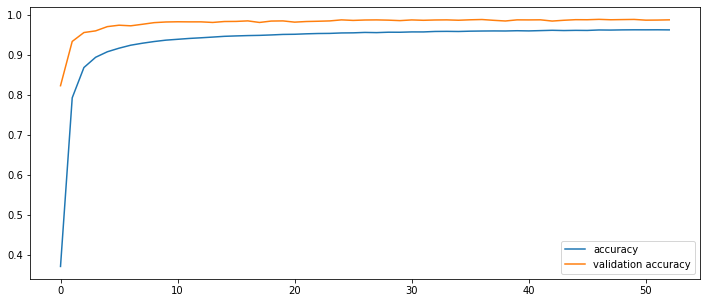

In [109]:
plt.figure(figsize = (12, 5))
plt.plot(history.history['accuracy'], label = "accuracy")
plt.plot(history.history['val_accuracy'], label = "validation accuracy")
plt.legend()

#Result

In [110]:
m.evaluate(features_dev, target_dev)

1278/1278 [==============================] - 7s 6ms/step - loss: 0.1805 - accuracy: 0.9880


[0.1804574877023697, 0.9879904389381409]

In [111]:
y_pred = m.predict(features_dev)

1278/1278 [==============================] - 7s 5ms/step


In [112]:
y_pred = np.argmax(y_pred, axis = 1)

In [119]:
print(tf.math.confusion_matrix(
    np.argmax(target_dev, axis = 1),
    y_pred,
))

tf.Tensor(
[[77  0  0 ...  0  0  0]
 [ 0 49  0 ...  0  0  0]
 [ 0  0 84 ...  0  0  0]
 ...
 [ 0  0  0 ... 46  0  0]
 [ 0  0  0 ...  0 48  0]
 [ 0  0  0 ...  0  0 44]], shape=(600, 600), dtype=int32)


In [121]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [122]:
m.save("drive/MyDrive/pfam.h5")
m.save_weights("drive/MyDrive/pfam_weights.h5")

In [123]:
import pickle
with open('drive/MyDrive/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer_seq, handle, protocol=pickle.HIGHEST_PROTOCOL)